## 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.inspection import permutation_importance

!pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 741 kB/s 


In [13]:
train = pd.read_csv('kuggle_train.csv')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76409 entries, 0 to 76408
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      76409 non-null  int64  
 1   hotel                           76409 non-null  object 
 2   lead_time                       76409 non-null  int64  
 3   arrival_date_year               76409 non-null  int64  
 4   arrival_date_month              76409 non-null  object 
 5   arrival_date_week_number        76409 non-null  int64  
 6   arrival_date_day_of_month       76409 non-null  int64  
 7   stays_in_weekend_nights         76409 non-null  int64  
 8   stays_in_week_nights            76409 non-null  int64  
 9   adults                          76409 non-null  int64  
 10  children                        76406 non-null  float64
 11  babies                          76409 non-null  int64  
 12  meal                            

In [15]:
train = train.drop(columns=['Unnamed: 0'],axis=1)

In [16]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: children입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: country입니다
해당 컬럼에 총 311개의 결측치가 존재합니다.
결측치가 있는 컬럼은: agent입니다
해당 컬럼에 총 10524개의 결측치가 존재합니다.
결측치가 있는 컬럼은: company입니다
해당 컬럼에 총 72097개의 결측치가 존재합니다.


In [17]:
# agent와 company로 예약했는지의 여부
train[['agent','company']] = train[['agent','company']].notna().astype(int)

In [18]:
# reserved_room_type과 assigned_room_type이 같은지의 여부
train['room'] = (train['reserved_room_type'] == train['assigned_room_type']).astype(int)

In [19]:
# 결측치를 모두 제거
train = train.dropna(axis=0)

In [20]:
# 원핫 인코딩
train = pd.get_dummies(train, columns = ['hotel'])

In [21]:
# month
train['arrival_date_month'] = train.arrival_date_month.map({'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5,
                                      'June' : 6, 'July' : 7, 'August' : 8, 'September' : 9, 'October' : 10, 'November' : 11, 'December' : 12})

In [22]:
# 타겟 인코딩
encoder = ce.target_encoder.TargetEncoder(cols=['meal', 'market_segment', 'customer_type', 'deposit_type'])
encoder.fit(train[['meal', 'market_segment', 'customer_type', 'deposit_type']], train['is_canceled']);
train[['meal', 'market_segment', 'customer_type', 'deposit_type']] = encoder.transform(train[['meal', 'market_segment', 'customer_type', 'deposit_type']])

In [23]:
train.groupby('is_canceled').count().iloc[:,0]

is_canceled
0    47785
1    28310
Name: lead_time, dtype: int64

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76095 entries, 0 to 76408
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       76095 non-null  int64  
 1   arrival_date_year               76095 non-null  int64  
 2   arrival_date_month              76095 non-null  int64  
 3   arrival_date_week_number        76095 non-null  int64  
 4   arrival_date_day_of_month       76095 non-null  int64  
 5   stays_in_weekend_nights         76095 non-null  int64  
 6   stays_in_week_nights            76095 non-null  int64  
 7   adults                          76095 non-null  int64  
 8   children                        76095 non-null  float64
 9   babies                          76095 non-null  int64  
 10  meal                            76095 non-null  float64
 11  country                         76095 non-null  object 
 12  market_segment                  

## EDA

In [ ]:
data_description = train.describe()
data_description

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,is_canceled,hotel_City Hotel,hotel_Resort Hotel,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA
count,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,...,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000,76095.000000
mean,104.230725,2016.157895,6.557133,27.186136,15.817715,0.927591,2.502635,1.858125,0.105237,0.008161,...,0.372035,0.667232,0.332768,0.002089,0.006321,0.042710,0.105579,0.166568,0.202747,0.473986
std,106.863037,0.708359,3.095096,13.623720,8.780420,0.998323,1.896836,0.575865,0.400102,0.102658,...,0.483351,0.471207,0.471207,0.045663,0.079254,0.202203,0.307299,0.372592,0.402048,0.499326
min,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2016.000000,4.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,160.000000,2017.000000,9.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,737.000000,2017.000000,12.000000,53.000000,31.000000,16.000000,41.000000,55.000000,3.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


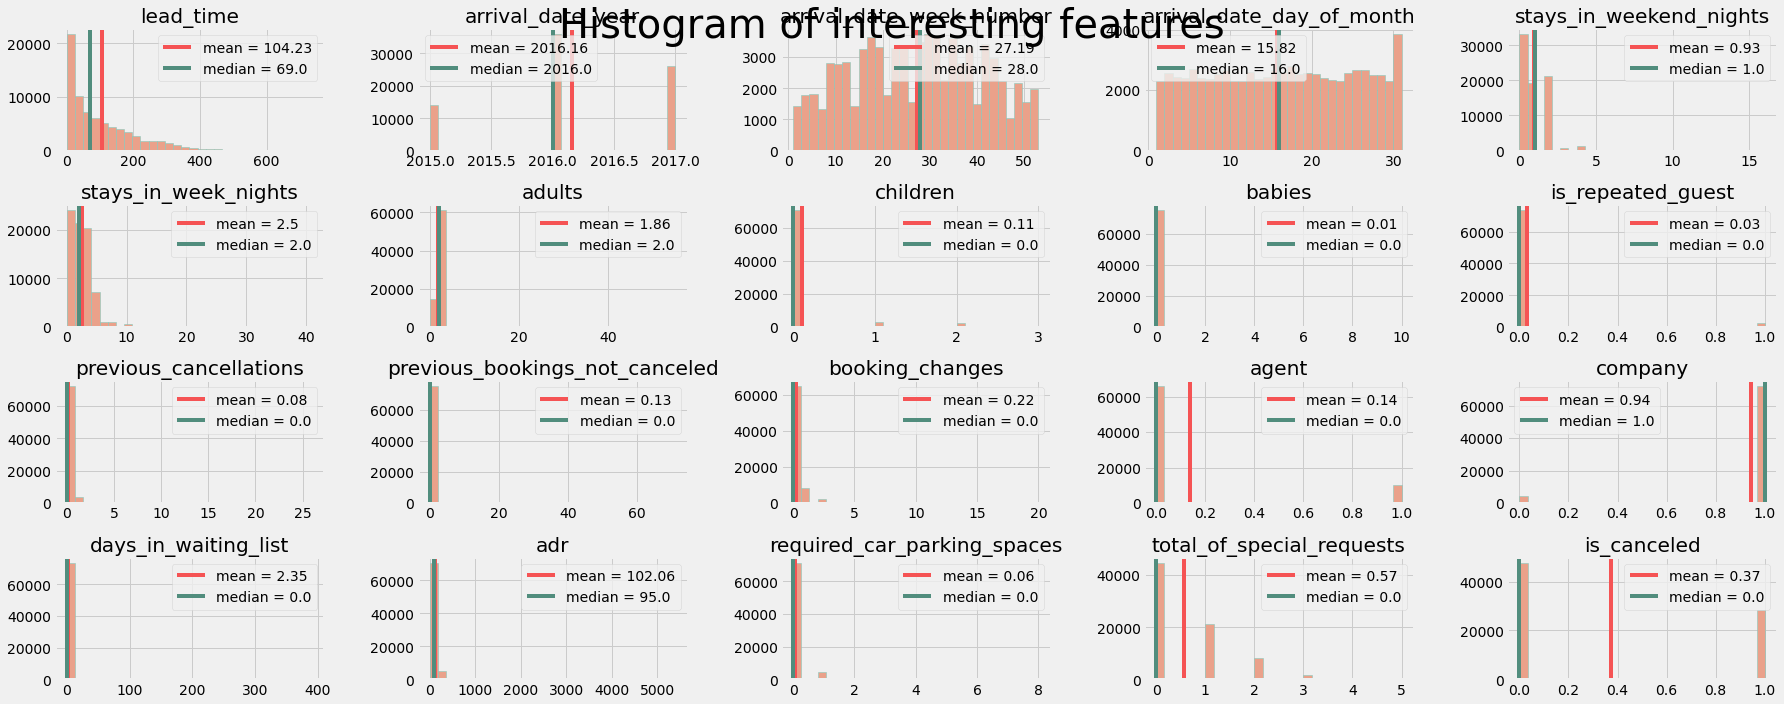

In [ ]:
interest_coloumns = ['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
                    'stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','is_repeated_guest',
                     'previous_cancellations','previous_bookings_not_canceled','booking_changes','agent','company','days_in_waiting_list',
                    'adr','required_car_parking_spaces','total_of_special_requests','is_canceled']
plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(4, 5, figsize = (25,10))
fig.suptitle('Histogram of interesting features', fontsize=40)
column_idx = 0
for i in range(4):
  for j in range(5):
    ax[i][j].hist(train[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
    ax[i][j].set_title(interest_coloumns[column_idx])
    ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(data_description[interest_coloumns[column_idx]]['mean'], 2)}")
    ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(data_description[interest_coloumns[column_idx]]['50%'], 2)}")
    ax[i][j].legend()
    column_idx += 1
fig.tight_layout()

In [ ]:
def visualize(axx, yfield):
	sns.regplot(x='is_canceled', y=yfield, data=train,  color='#eaa18a', line_kws=  {'color': '#f55354'} , ax = axx)
	axx.set_title(yfield)

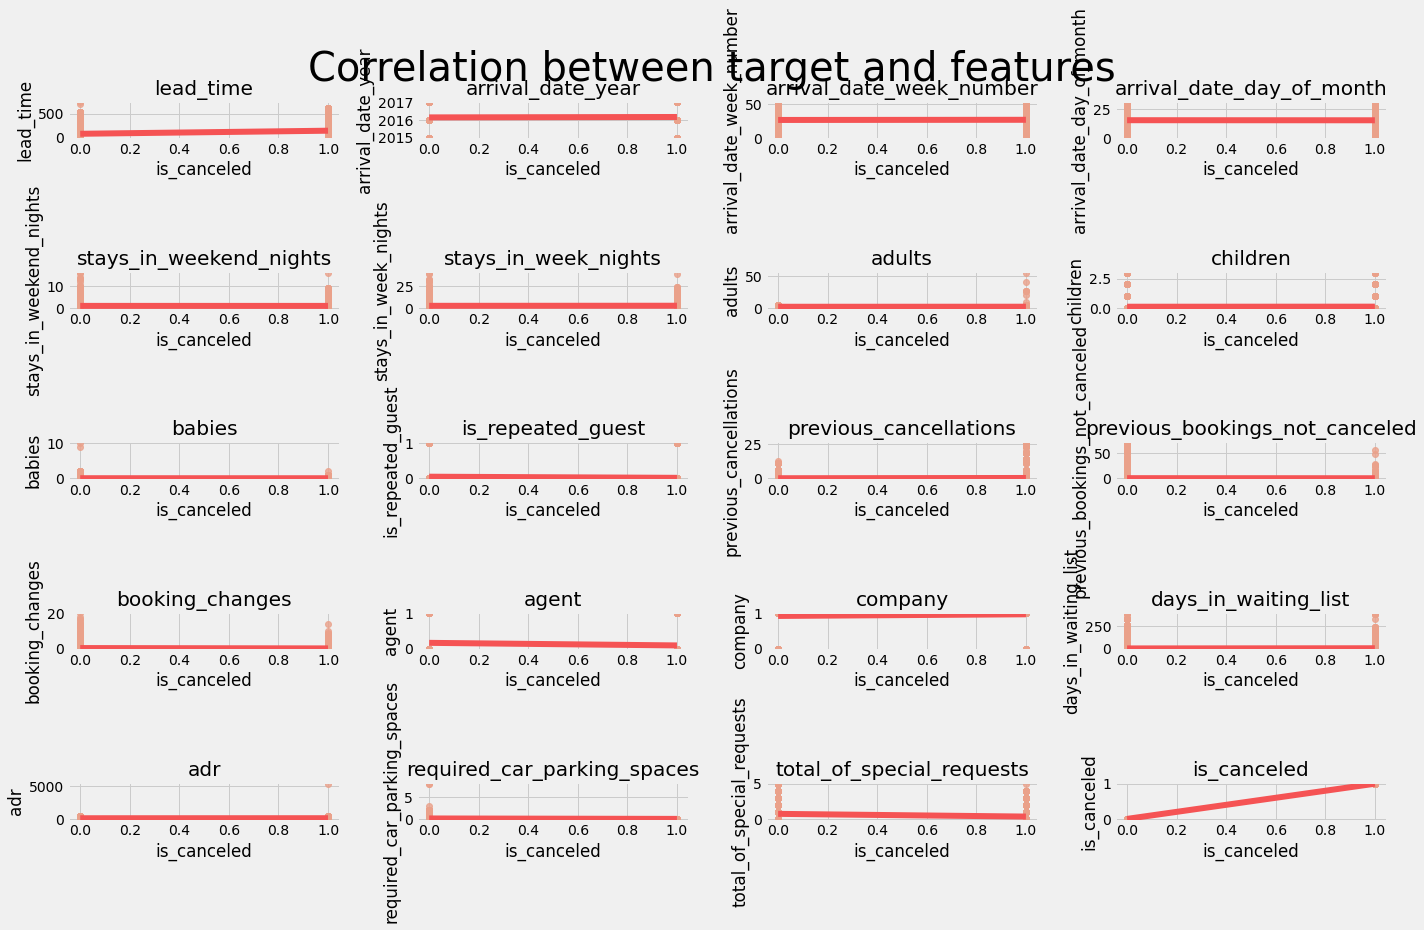

In [ ]:
figure, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16),(ax17,ax18,ax19,ax20)) = plt.subplots(nrows=5, ncols=4)
figure.set_size_inches(20,12)
figure.suptitle('Correlation between target and features', fontsize=40)
for i in range(len(interest_coloumns)):
	visualize(eval(f'ax{i+1}'),interest_coloumns[i])
figure.tight_layout()

In [ ]:
train_corr = train[['lead_time','arrival_date_year','arrival_date_day_of_month','arrival_date_week_number',
                    'stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','is_repeated_guest',
                     'previous_cancellations','previous_bookings_not_canceled','booking_changes','agent','company','days_in_waiting_list',
                    'adr','required_car_parking_spaces','total_of_special_requests','is_canceled']]

corr28 = train_corr.corr(method= 'pearson')

Text(0.5, 1.0, 'Correlation between features')

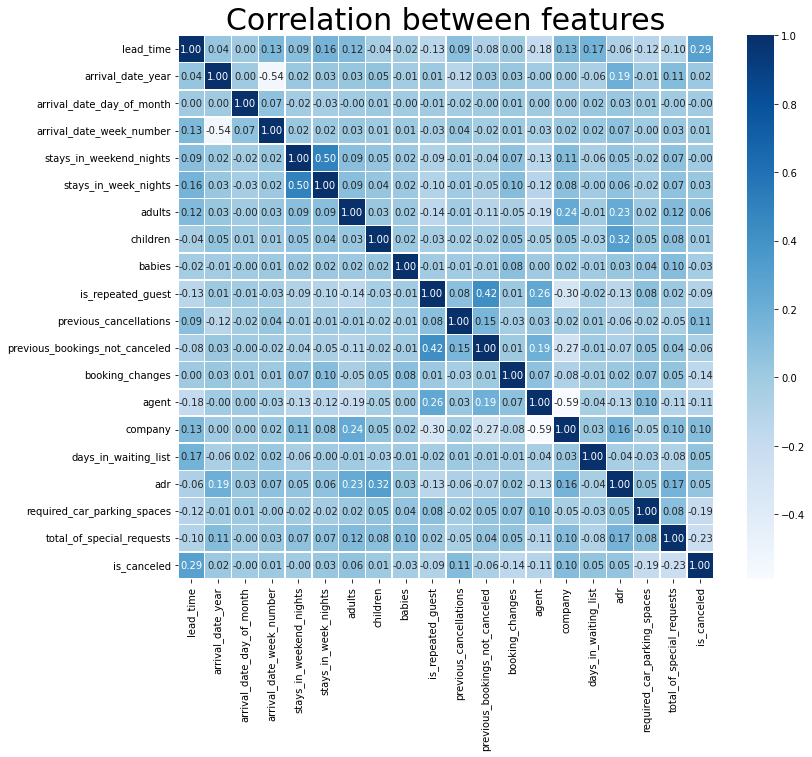

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

## 파라미터 튜닝

In [ ]:
train = train.drop(['country', 'distribution_channel', 'name', 'email', 'phone-number', 'credit_card'], axis = 1)

In [ ]:
X = train.drop(["is_canceled"], axis = 1)
y = train['is_canceled']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [ ]:
# RandomForest parameter 구성

rf_clf = RandomForestClassifier(random_state=777)

grid_parameters={'max_depth':[8,10,12], 'min_samples_leaf':[3,4,5], 'n_estimators':[100,150,200]}
grid_rf = GridSearchCV(rf_clf, param_grid = grid_parameters, cv = 3, refit = True)
grid_rf.fit(X_train,y_train)

print('GridSearchCV 최적 파라미터:',grid_rf.best_params_)
print("GridSearchCV 최고 정확도:",grid_rf.best_score_)

GridSearchCV 최적 파라미터: {'max_depth': 12, 'min_samples_leaf': 3, 'n_estimators': 150}
GridSearchCV 최고 정확도: 0.8233950982324725


In [ ]:
# Decision tree parameter 구성

dt_clf = DecisionTreeClassifier(random_state=777)

grid_parameters={'max_depth':[8,10,12],'min_samples_leaf':[3,4,5],'min_samples_split':[2,3,4]}
grid_dtree = GridSearchCV(dt_clf, param_grid=grid_parameters, cv = 3, refit = True)
grid_dtree.fit(X_train,y_train)

print('GridSearchCV 최적 파라미터:',grid_dtree.best_params_)
print("GridSearchCV 최고 정확도:",grid_dtree.best_score_)

GridSearchCV 최적 파라미터: {'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8165779617583283


In [ ]:
# GB parameter 구성

gb = GradientBoostingClassifier(random_state=777)

grid_parameters={'max_depth':[4,5],'learning_rate':[0.3,0.4],'min_samples_leaf':[3,4]}
grid_gb = GridSearchCV(gb, param_grid=grid_parameters, cv = 3, refit = True)
grid_gb.fit(X_train,y_train)

print('GridSearchCV 최적 파라미터:',grid_gb.best_params_)
print("GridSearchCV 최고 정확도:",grid_gb.best_score_)

GridSearchCV 최적 파라미터: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 4}
GridSearchCV 최고 정확도: 0.8417931532952231


In [ ]:
# XGB parameter 구성

xgb = XGBClassifier(random_state=777)

grid_parameters={'max_depth':[4,5],'early_stopping_rounds':[100,200],'learning_rate' :[0.3,0.4]}
grid_xgb = GridSearchCV(xgb, param_grid=grid_parameters, cv = 3, refit = True)
grid_xgb.fit(X_train,y_train)

print('GridSearchCV 최적 파라미터:',grid_xgb.best_params_)
print("GridSearchCV 최고 정확도:",grid_xgb.best_score_)

GridSearchCV 최적 파라미터: {'early_stopping_rounds': 100, 'learning_rate': 0.4, 'max_depth': 5}
GridSearchCV 최고 정확도: 0.842368092515934


In [ ]:
# Adaboost parameter 구성

ada = AdaBoostClassifier(random_state=777)

grid_parameters={'n_estimators':[100,200],'learning_rate':[0.3,0.4]}
grid_ada = GridSearchCV(ada, param_grid=grid_parameters, cv = 3, refit = True)
grid_ada.fit(X_train,y_train)

print('GridSearchCV 최적 파라미터:',grid_ada.best_params_)
print("GridSearchCV 최고 정확도:",grid_ada.best_score_)

GridSearchCV 최적 파라미터: {'learning_rate': 0.4, 'n_estimators': 200}
GridSearchCV 최고 정확도: 0.8139989486825678


In [ ]:
# LogisticRegression parameter 구성

lgr = LogisticRegression(random_state=777)

grid_parameters = {'penalty':['l2', 'l1'],'C':[0.01, 0.1, 1]}
grid_lgr = GridSearchCV(lgr, param_grid = grid_parameters, cv = 3, refit = True)
grid_lgr.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터:',grid_lgr.best_params_)
print("GridSearchCV 최고 정확도:",grid_lgr.best_score_)

GridSearchCV 최적 파라미터: {'C': 1, 'penalty': 'l2'}
GridSearchCV 최고 정확도: 0.7422793876075957


## Voting

In [ ]:
# Soft Voting

rf_clf = RandomForestClassifier(max_depth= 12, min_samples_leaf=3, n_estimators=150,random_state=42)
dt_clf = DecisionTreeClassifier(max_depth= 12, min_samples_leaf= 5, min_samples_split=2,random_state=42) 
gb = GradientBoostingClassifier(learning_rate = 0.3, max_depth=5, min_samples_leaf=4,random_state=42)
xgb = XGBClassifier(early_stopping_rounds = 100, learning_rate = 0.4, max_depth= 5,random_state=42)
ada = AdaBoostClassifier(learning_rate = 0.4, n_estimators = 200, random_state=42)
lgr = LogisticRegression(penalty='l2', C=1 , random_state=42)

vo_clf=VotingClassifier(estimators=[('RF',rf_clf),('DT', dt_clf),('GB',gb),('XGB',xgb),('ADA',ada),('LGR',lgr)], voting='soft', random_state=777)

vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
print( "Soft Voting 정확도:",accuracy_score(y_test,pred))

Soft Voting 정확도: 0.8415796044418161
